In [10]:
from util_plot import plot_hist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import os
import copy
import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
import time
import collections
from sklearn.model_selection import KFold
from matplotlib.lines import Line2D

In [11]:
Z_var_list=['HH_RACE_MINORITY','FEMALE','POVERTY','MEDCOND_NEW', 'RURAL']
Z_note_list=['Race','Female','Poverty','Medcond','Rural']
Z_ontitle=['Race','Gender','Income','Medical Condition','Region']
Z_onlabel=[['Minority','Majority'],['Female','Male'],['Low','Middle or High'],['With','Without'],['Rural','Urban']]

# Fairness visualization

In [12]:
folder='Mode'#'WFH_Group'
layer=3#0
plot_hist(folder,layer,Z_var_list,Z_note_list,Z_ontitle,Z_onlabel)

# Regularization visualization

In [4]:
folder='Mode'#'WFH_Group'

if folder=='Mode':
    data_varlist=['RIDESHARE_NEW']
    name_corelist=['Rideshare']

    Z_var_list=['RURAL']
    Z_note_list=['Rural']
    
else:
    data_varlist=['PLACE']
    name_corelist=['TB']
    
    Z_var_list=['HH_RACE_MINORITY']
    Z_note_list=['Race']


In [5]:
lists=['train_list','test_list','std_train_list','std_test_list','max_train_list','min_train_list',\
       'max_test_list','min_test_list']
datatype='Original'
layer=3

if layer==3:
    model_path ='model_3lyr_'
elif layer==0:
    model_path ='model_base_'

models=['logit','NN']
lam_list=[0,0.2,0.4,0.6,0.8]


var_dic={}
for model in models:
    if model=='NN':
        model_path ='model_3lyr_'
    elif model=='logit':
        model_path ='model_base_'
    
    var_dic[model]={}
    v='corr'
    var_dic[model][v]={}
    for stat in ['FNR_gap','FPR_gap','accuracy']:
        var_dic[model][v][stat]={}
        for li in lists:
            var_dic[model][v][stat][li]=[]
    for k in zip(data_varlist,name_corelist):
        run_name =model_path+k[1]#e.g.model_base_Bus

        for a in zip(Z_var_list,Z_note_list):
            for lam in lam_list:
                if lam==0:
                    with open('results/' + folder+'/'+ datatype+'/'+ a[1]+'/'+run_name+'.pkl', 'rb') as f:
                        pic_dic = pickle.load(f)
                else:
                    with open('results/' + folder+'/'+ datatype+'/'+ a[1]+'/'+run_name+'_lam'+str(lam)+'.pkl', 'rb') as f:
                        pic_dic = pickle.load(f)

                for stat in ['FNR_gap','FPR_gap','accuracy']:
                    if folder!='Mode' or stat!='FPR_gap':
                        var_dic[model][v][stat]['train_list'].append(np.array(pic_dic['train_'+stat])[0,:].mean())
                        var_dic[model][v][stat]['test_list'].append(np.array(pic_dic['test_'+stat])[0,:].mean())
                        var_dic[model][v][stat]['std_train_list'].append(np.array(pic_dic['train_'+stat])[0,:].std())
                        var_dic[model][v][stat]['std_test_list'].append(np.array(pic_dic['test_'+stat])[0,:].std())
                        var_dic[model][v][stat]['max_train_list'].append(np.array(pic_dic['train_'+stat])[0,:].max())
                        var_dic[model][v][stat]['max_test_list'].append(np.array(pic_dic['test_'+stat])[0,:].max())
                        var_dic[model][v][stat]['min_train_list'].append(np.array(pic_dic['train_'+stat])[0,:].min())
                        var_dic[model][v][stat]['min_test_list'].append(np.array(pic_dic['test_'+stat])[0,:].min())
                        var_dic[model][v][stat]['x_value']=lam_list

[0.6241191118118444, -0.06435703895542404, -0.04721531482425211, -0.0438433568157436, -0.06078347949533114]
[0.7770902289028854, 0.7656673, 0.7660543, 0.7638228, 0.75897586]


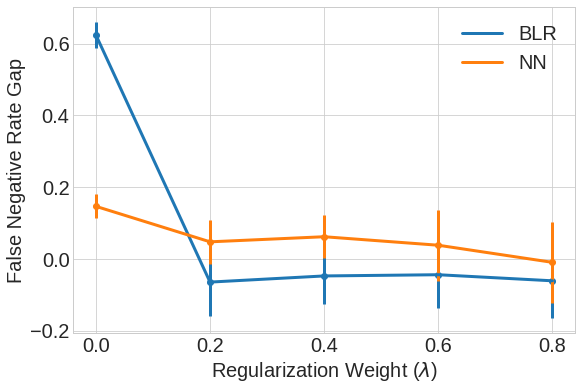

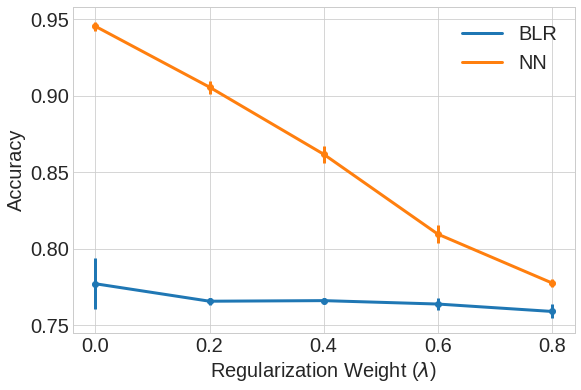

In [9]:
title_name={}
title_name['FNR_gap']='False Negative Rate Gap'
title_name['FPR_gap']='False Positive Rate Gap'
title_name['accuracy']='Accuracy'
plt.style.use('seaborn-whitegrid')

if folder=='Mode':
    stats=['FNR_gap','accuracy']
else:
    stats=['FPR_gap','accuracy']
for stat in stats:
    plt.figure(figsize=(9,6))
    for model in models:
        if model=='logit':
            print(var_dic[model][v][stat]['test_list'])

        ci = 1.96 * np.array(var_dic[model][v][stat]['std_test_list'])
        plt.scatter(var_dic[model][v][stat]['x_value'], var_dic[model][v][stat]['test_list'])
        plt.errorbar(var_dic[model][v][stat]['x_value'], var_dic[model][v][stat]['test_list'],yerr=ci,lw=3)
        plt.xlabel('Regularization Weight ($\lambda$)',fontsize=20) 


    plt.ylabel(title_name[stat],fontsize=20) 
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    legend_elements = [Line2D([0], [0], color='C0', lw=3 , label='BLR'),
        Line2D([0], [0], color='C1' , lw=3,label='NN')]
    plt.legend(handles=legend_elements,prop={'size': 20})

#     plt.savefig('plots/' +  folder+'/'+stat+'_mitigation.png', bbox_inches="tight", dpi=300)

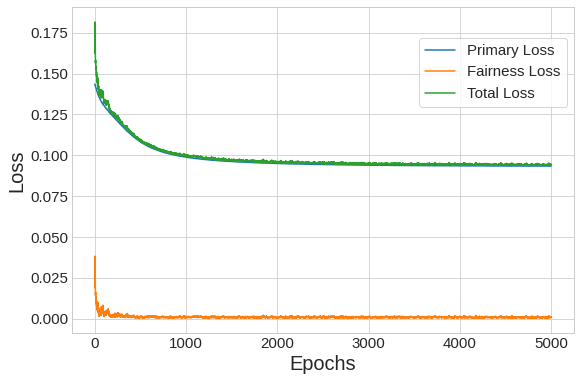

In [90]:
#Training process visualization
n_epoch=5000
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9,6))
plt.plot(list(range(n_epoch)), cost1_li.T) 
plt.plot(list(range(n_epoch)), cost2_li.T)
plt.plot(list(range(n_epoch)), cost_li.T) 
plt.legend(['Primary Loss','Fairness Loss','Total Loss'], fontsize=15,\
           loc='center right', bbox_to_anchor=(1, 0.8), frameon=True)
plt.xlabel('Epochs',fontsize=20) 
plt.ylabel('Loss',fontsize=20) 
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.title('') 
plt.savefig('plots/' +  folder+'/'+ model_path+'/mitigation/'+a[1]+'_'+k[1]+'_'+'training.png', bbox_inches="tight", dpi=500)